# **Training Deep Neural Networks on a GPU with PyTorch**

With MNIST Dataset

## Preparing the Data

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [3]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
batch_size=128

## Data Loader

In [6]:
train_loader = DataLoader(
                          train_ds, 
                          batch_size, 
                          shuffle=True, 
                          num_workers=4, 
                          pin_memory=True
                         )

val_loader = DataLoader(
                        val_ds, 
                        batch_size*2, 
                        num_workers=4, 
                        pin_memory=True
                       )



images.shape: torch.Size([128, 1, 28, 28])


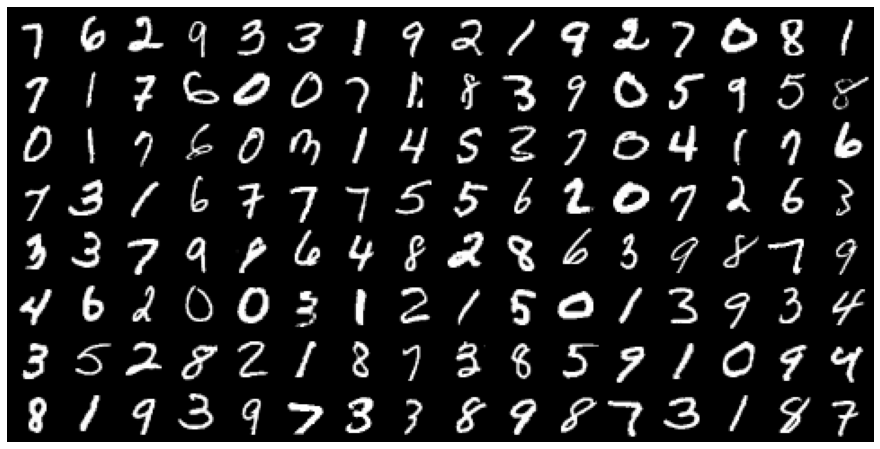

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## **Model**

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

> So to improve upon Logistic regression we will implement Neural netwrok.

> And this is where neural network comes into play after this our model becomes a neural network with one hidden layer.

In [9]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)# This is the Hidden layer
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)   # This is the activation Function 
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [10]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [11]:
MnistModel

__main__.MnistModel

In [12]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [13]:
model   # we can have a look at our mmodeland number of hidden layers

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [14]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


IN the above:- 
We have 784 as outputs to 32 and then again finally to 10 outputs

In [15]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.326073408126831
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0621, -0.0725, -0.1819, -0.0895,  0.1606, -0.2262, -0.2264,  0.0066,
          0.0950,  0.2001],
        [ 0.0085, -0.0634, -0.0739, -0.0516,  0.1210, -0.2788, -0.1023, -0.0041,
          0.0596,  0.1611]])


## **Using a GPU**

In [16]:
torch.cuda.is_available()

True

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [18]:
device = get_default_device()
device

device(type='cuda')

## Lets move all our data and the model to a choosen device

In [19]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [20]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [21]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
train_loader = DeviceDataLoader(
                                train_loader, 
                                device
                               )
val_loader = DeviceDataLoader(
                              val_loader, 
                              device
                             )

In [23]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([1, 4, 8, 4, 1, 0, 9, 4, 9, 5, 8, 4, 4, 2, 4, 1, 1, 2, 4, 2, 7, 4, 8, 6,
        1, 4, 2, 6, 4, 7, 8, 3, 7, 2, 0, 6, 0, 4, 3, 2, 3, 2, 7, 8, 2, 1, 2, 2,
        2, 3, 0, 8, 0, 2, 0, 5, 1, 9, 6, 6, 5, 9, 0, 3, 1, 8, 5, 1, 7, 1, 1, 8,
        5, 3, 5, 1, 1, 2, 5, 3, 0, 7, 3, 3, 0, 1, 4, 9, 1, 9, 4, 0, 6, 9, 5, 7,
        6, 1, 1, 5, 2, 4, 8, 6, 9, 3, 3, 2, 7, 6, 3, 3, 4, 5, 5, 5, 5, 1, 2, 2,
        5, 2, 5, 4, 9, 0, 1, 3, 9, 1, 1, 6, 8, 1, 8, 7, 8, 7, 8, 5, 5, 3, 4, 1,
        8, 6, 9, 5, 3, 2, 9, 8, 5, 3, 2, 5, 2, 1, 6, 3, 2, 0, 1, 3, 1, 4, 1, 9,
        6, 5, 9, 2, 5, 0, 9, 7, 8, 2, 3, 4, 1, 4, 9, 7, 8, 3, 2, 9, 6, 6, 3, 0,
        1, 2, 7, 4, 7, 5, 6, 0, 9, 3, 2, 5, 6, 4, 1, 7, 6, 6, 9, 2, 3, 0, 7, 7,
        8, 1, 3, 2, 3, 9, 0, 1, 7, 8, 5, 2, 3, 3, 6, 6, 9, 6, 6, 2, 9, 7, 0, 9,
        9, 6, 3, 5, 5, 8, 4, 5, 3, 5, 2, 8, 6, 2, 7, 7], device='cuda:0')


## **Training the Model**

In [24]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [26]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.11650390923023224, 'val_loss': 2.302107572555542}]

In [27]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2063, val_acc: 0.9402
Epoch [1], val_loss: 0.1998, val_acc: 0.9405
Epoch [2], val_loss: 0.1557, val_acc: 0.9517
Epoch [3], val_loss: 0.1415, val_acc: 0.9573
Epoch [4], val_loss: 0.1301, val_acc: 0.9600


In [28]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1082, val_acc: 0.9659
Epoch [1], val_loss: 0.1035, val_acc: 0.9676
Epoch [2], val_loss: 0.1054, val_acc: 0.9667
Epoch [3], val_loss: 0.0997, val_acc: 0.9688
Epoch [4], val_loss: 0.1005, val_acc: 0.9678


In [29]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [30]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x', color='red')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

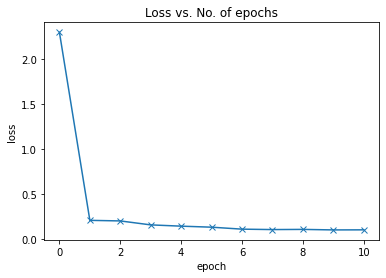

In [31]:
plot_losses(history)

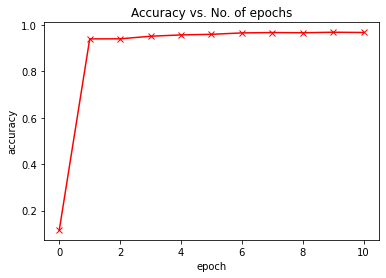

In [32]:
plot_accuracies(history)

In [33]:
evaluate(model, val_loader)

{'val_acc': 0.9677734375, 'val_loss': 0.10052694380283356}

## **So Hence we can see our model outperforms Logistic Regression by a verry Huge Margin**

## Lets Predict

In [34]:
# Prediction on Samples
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 1 - one , Predicted: 1 - one


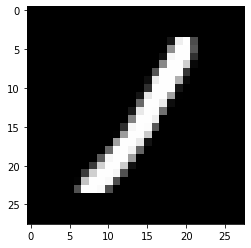

In [38]:
img, label = dataset[905]
plt.imshow(img[0], cmap='gray')
print('Label:', dataset.classes[label], ', Predicted:', dataset.classes[predict_image(img, model)])

# **THE END**